# NYC Yellow Cab Efficiency
---

> Independent project to explore the impact of shared rides on the efficiency of NYC transit by using trip aggregation strategies on NYC Yellow Cab trip data. I provide an estimate of gained efficiency if we switch from traditional yellow cab rides to aggressive ride sharing strategies. My approach starts by defining an efficiency metric and an aggregation strategy and then I compare the distribution of efficiency of yellow cabs and ride shares across a range of spatial and temporal gradients within Manhattan. 

## Contents
1. <a href='#1'>Definining an efficiency metric </a>
    * Formal definition.
    * Assumptions and simplifications.
    * Setup environment.
2. <a href='#2'>Data processing pipeline to calculate efficiency </a>
    * Intro to aggregation strategy.
    * Get trips in Manhattan.
    * Cleanup data and calculate efficiency.
3. <a href='#3'>Aggregation strategy </a>
    * Aggregation function.
    * Find optimal waiting time threshold. 
4. <a href='#4'>Compare efficiency for modes of transportation in Manhattan </a>
    * NYC Yellow cabs vs. Aggregated rides.
    * Walking and biking baselines. 
5. <a href='#5'>Visualizations for spatial and temporal trends in efficiency </a>
    * Neighborhood network maps.
    * Efficiency vs. time of day and time of the week.
6. <a href='#6'>Conclusions </a>
    * Take home points.
    * Next steps.


### Defining an efficiency metric for NYC transport: <a id=1></a>
$$ \textbf{Efficiency} = \frac{\textit{Passenger displacement}}{\textit{cost}} $$
$$ \textbf{Passenger displacement} = \mu_{\textit{distance covered}} * \mu_{\textit{number of passengers}} $$
$$ \textbf{Cost} = \textit{(fuel cost + social carbon cost) * miles + idle time} + \textit{(drive salary + oppotunity cost) time} $$


#### Passenger displacement:
* Distance travelled by each passenger.
* Adds up when multiple passengers share a ride.

#### Cost components:
1. Driver salary 
    * $\$$20 / hour fixed salary.
2. Fuel cost
    * Assumes 13 mpg fuel efficiency.
    * Assumes 25 mph average crusing speed to determine idle time and 0.5 gallon per hour consumption when idle.
    * Based on a $\$$2.385 gallon and a $\$$0.453 social carbon cost per gallon emissions.
3. Opportunity cost 
    * $\$$15 / hour opportunity cost per passenger for commuting.

#### Assumptions:
* Trips beginning and ending in Manhattan have twice the weight of those that only begin or end in Manhattan when determing efficiency. 
* Pickup and dropoff walking distances are are set to the Manhattan distance between pairs of pickup and dropoff points.
* Shared rides can take up to 6 passengers at once.
* Passengers can only aggregate at the beginning of a trip (i.e. no pickups or dropoffs mid-route).
* Traffic speed, fuel cost and driver salary are the same for non-aggregated and aggregated rides.

#### Data pipeline:
* 1st full week of June 2016 $\Rightarrow$ training (find optimal waiting time).
* 2nd full week of June 2016 $\Rightarrow$ validation (compare aggregated vs. yellow cab efficiency).


#### Load packages and read input data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from functools import partial
from collections import Counter, defaultdict
from multiprocessing import Pool, cpu_count
from sklearn import gaussian_process as gp
import plotnine as p9
import time

# gis imports
import geopandas as gpd
import folium
from shapely.geometry import Point, LineString, Polygon
from shapely.strtree import STRtree
from shapely.ops import nearest_points
from scipy.spatial import cKDTree
import osmnx as ox

# get data from google bigquerry
import pandas_gbq
from google.cloud import bigquery
%load_ext google.cloud.bigquery

# set seed for reproducibility
np.random.seed(4)


query = '''SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, 
                  dropoff_longitude, trip_distance, passenger_count
           FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
           WHERE pickup_datetime BETWEEN '2016-06-05' AND '2016-06-20' AND
                 pickup_datetime < dropoff_datetime
'''


# read input data
pd.set_option('display.float_format', lambda x: '%.5f' % x)
boroughs = gpd.read_file('Borough_Boundaries/geo_export_acd45f17-302a-4908-b0d7-223e9510dc04.shp')
trips_all = pd.read_gbq(query, project_id='yellowcab-2021')
manhattan = boroughs.loc[boroughs.boro_name == 'Manhattan', 'geometry'].values[0]
boroughs['city'] = ['NYC'] * len(boroughs)
all_boroughs = boroughs.dissolve(by='city').geometry.values[0]
trips_all.describe()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance,passenger_count
count,5549694.00000,5549694.00000,5549694.00000,5549694.00000,5549694.00000,5549694.00000
mean,40.24062,-73.04688,40.31694,-73.18381,3.06842,1.66022
std,4.53074,8.22463,4.18654,7.59987,3.86126,1.30332
min,0.00000,-118.18626,0.00000,-118.18626,0.00000,0.00000
25%,40.73602,-73.99182,40.73462,-73.99125,1.00000,1.00000
50%,40.75331,-73.98141,40.75397,-73.97939,1.74000,1.00000
75%,40.76846,-73.96597,40.76978,-73.96185,3.30000,2.00000
max,51.29756,0.00000,50.32283,106.24688,805.90000,9.00000


## Calculating efficiency <a id=2></a>
---

* Create function to get trips starting or ending in Manhattan.
* Create function to get efficiency and emissions for those trips.
* Calculate efficiency for Yellow cabs in Manhattan.


#### Function to get Manhattan trips

In [2]:
def get_trips_polygon(df: pd.DataFrame, polygon: Polygon, bounds: Polygon=None) -> pd.DataFrame:
    """
    Helper function to subset trips to those starting and/or ending inside a georefrenced polygon
    Inputs:
    df: pandas DataFrame with trips
    polygon: shapely polygon
    """
    # create columns for point geometries
    points_pick = [Point(*ele) for ele in zip(df['pickup_longitude'], df['pickup_latitude'])]
    points_drop = [Point(*ele) for ele in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
    pick_id = [id(ele) for ele in points_pick]
    drop_id= [id(ele) for ele in points_drop]
               
    # create a dictionary from id to index
    id_to_idx = {point_id: df.index[idx] for idx, point_id in enumerate(pick_id)}
    for idx, point_id in enumerate(drop_id):
        id_to_idx[point_id] = df.index[idx]
    
    # create R-tree for points to query 
    pick_tree = STRtree(points_pick)
    drop_tree = STRtree(points_drop)
    
    # filter to stay within 4 borough boundaries
    if bounds:
        query_pick = pick_tree.query(bounds)
        quert_drop = drop_tree.query(bounds)
        ids_pick = set([id_to_idx[id(ele)] for ele in query_pick])
        ids_drop = set([id_to_idx[id(ele)] for ele in quert_drop])
        df = df.loc[list(ids_pick.intersection(ids_drop))]
        
        # update trees
        pick_tree = STRtree(query_pick)
        drop_tree = STRtree(quert_drop)

    # chop polygon into quadrats for R-Tree searching
    pol_cut = ox.utils_geo._quadrat_cut_geometry(polygon, quadrat_width=0.025)
    
    # loop through quadrats storing points that start or end in each quadrant
    ids_pick = set()
    ids_drop = set()
    for quadrat in pol_cut:
        drop_quadrat = set([id_to_idx[id(ele)] for ele in drop_tree.query(quadrat)])
        pick_quadrat = set([id_to_idx[id(ele)] for ele in pick_tree.query(quadrat)])
        ids_drop = ids_drop.union(drop_quadrat)
        ids_pick = ids_pick.union(pick_quadrat)
    
    # keep points that start or end in Manhattan, give extra weight to those that do both
    weight2_trips = list(ids_drop.intersection(ids_pick))
    df = df.loc[df.index.isin(list(ids_pick.union(ids_drop)))]
    df = df.assign(weight=[1] * len(df))
    df.loc[weight2_trips, 'weight'] = 2

    # return df
    return df


#### Get all Manhattan trips during the second week of June 2016

In [3]:
# subset trips by date
trips = trips_all.loc[[12 <  ele.day < 20 for ele in trips_all.pickup_datetime]]

# subset by location and add geometries and weights
tic = time.time()
chunks = (trips.iloc[idx:idx + 10000] for idx in range(0, len(trips), 10000))
pool = Pool(cpu_count() - 1)
results = pool.map_async(partial(get_trips_polygon, polygon=manhattan,
                                bounds=all_boroughs), chunks)
trips = results.get()
pool.close()
pool.join()
print(f'Finished processing trips in {time.time() - tic} seconds')

# subset trips and explore resulting data
trips = pd.concat(trips)
trips = trips.assign(total_wait=[0] * len(trips)) 
trips.describe()

Finished processing trips in 62.35834813117981 seconds


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance,passenger_count,weight,total_wait
count,2431065.00000,2431065.00000,2431065.00000,2431065.00000,2431065.00000,2431065.00000,2431065.00000,2431065.00000
mean,40.75263,-73.97651,40.75334,-73.97534,2.91295,1.65863,1.87540,0.00000
std,0.02542,0.03227,0.03014,0.03220,3.62347,1.30360,0.33027,0.00000
min,40.51811,-74.22618,40.51123,-74.25534,0.00000,0.00000,1.00000,0.00000
25%,40.73904,-73.99229,40.73818,-73.99157,1.00000,1.00000,2.00000,0.00000
50%,40.75475,-73.98210,40.75529,-73.98035,1.70000,1.00000,2.00000,0.00000
75%,40.76853,-73.96908,40.77034,-73.96519,3.12000,2.00000,2.00000,0.00000
max,40.90976,-73.71921,40.91549,-73.70019,805.90000,9.00000,2.00000,0.00000


#### Cleanup trip data
* There is no missing data on columns of interest.
* Some trips have a passenger count of zero.
* Some trips have zero distance.
* Some trips have an unrealistic distance (> 500 mi).
* Some trips have unrealistic duration given their distance (maybe the driver forgot to turn off the meter?).

#### Data imputation strategy:
* Substitute passenger counts of zero with a sample from passenger counts.
* Substitute missing / unrealistic distances with Manhattan distances.

In [4]:
# get number of trips with zero distance, zero passengers and unrealisticly high distances
print(f'Number of trips with zero distance: {len(trips.loc[trips.trip_distance == 0])}')
print(f'Number of trips with zero passengers: {len(trips.loc[trips.passenger_count == 0])}')
print(f'Number of trips over 50 miles:  {len(trips.loc[trips.trip_distance > 50])}')

# Helper function top get manhattan distances between vectors of lat, lon
def manhattan_dist(lat1, lat2, lon1, lon2):
    dlat = abs(lat1 - lat2)
    dlon = abs(lon1 - lon2)
    return 69 * dlat + 69 * dlon * np.cos(np.radians(lon2)) 

# function to clean trips
def cleanup_trips(trips: pd.DataFrame, minimum_speed=3.4):
    
    # make sure tip duration is reasonable given trip distance
    trips = trips.loc[(trips.trip_distance / ((trips['dropoff_datetime'] - \
                                              trips['pickup_datetime']).astype('timedelta64[s]') / 3600)) > minimum_speed]
    
    # fill zero passenger count trips sampling from observed passenger counts
    passenger_counts = list(trips.loc[trips.passenger_count > 0].passenger_count)
    trips.loc[trips.passenger_count == 0, 'passenger_count'] = np.random.choice(passenger_counts, 
                         size=len(trips.loc[trips.passenger_count == 0]))

    # fill trips with unrealistic or zero distance using the Manhattan distance 
    dist_trips = trips.loc[(trips.trip_distance < 50) & (trips.trip_distance != 0)]
    trips.loc[(trips.trip_distance < 50) | (trips.trip_distance != 0), 'trip_distance'] =  \
        manhattan_dist(dist_trips.pickup_latitude, dist_trips.dropoff_latitude, 
                       dist_trips.pickup_longitude, dist_trips.dropoff_longitude)

    return trips

# clean trips and display new values
trips = cleanup_trips(trips)
trips.describe()

Number of trips with zero distance: 6498
Number of trips with zero passengers: 45
Number of trips over 50 miles:  26


/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_distance,passenger_count,weight,total_wait
count,2380273.00000,2380273.00000,2380273.00000,2380273.00000,2380247.00000,2380273.00000,2380273.00000,2380273.00000
mean,40.75260,-73.97641,40.75332,-73.97519,1.95534,1.65928,1.87311,0.00000
std,0.02555,0.03251,0.03035,0.03243,2.09565,1.30403,0.33284,0.00000
min,40.51811,-74.17875,40.51123,-74.25534,0.00000,1.00000,1.00000,0.00000
25%,40.73881,-73.99233,40.73792,-73.99159,0.71335,1.00000,2.00000,0.00000
50%,40.75472,-73.98211,40.75526,-73.98022,1.27950,1.00000,2.00000,0.00000
75%,40.76870,-73.96890,40.77059,-73.96481,2.39205,2.00000,2.00000,0.00000
max,40.90976,-73.71921,40.91549,-73.70019,21.61685,9.00000,2.00000,0.00000


#### Efficiency function

In [5]:
# function to get efficiency for trip
def get_efficiency(trips, gallon_price: float=2.385, mpg: float=13.0,
                   social_carbon_cost: float=0.453, idle_cost: float=0.5, 
                   avg_speed: float=25.0, driver_salary: float=20.0, 
                   opportunity_cost: float=15.0) -> pd.DataFrame:
    """
    Determines the efficiency of a trip as passenger displacement / trip cost
    
    gallon_price (float): price of a gallon of fuel in US$
    mpg (float): miles per gallon for vehicles
    idle_cost: gallons consumed per hour when car is idle
    avg_speed: average speed in mph when not suck in traffic
    driver_salary: driver hourly pay in US$
    opportunity_cost: hourly ocpportunity cost for passengers in US$
    
    returns: efficiency for trip, doubled if it starts and ends within Manhattan 
    """
    # add extra weight to manhattan trips
    trips = trips.append(trips.loc[trips.weight == 2], ignore_index=True)
    
    # get displacement
    displacement = trips['trip_distance'] * trips['passenger_count']
    
    # get duration in hours
    duration = (trips['dropoff_datetime'] - trips['pickup_datetime']).astype('timedelta64[s]') / 3600
    
    # get fuel and driver cost
    idle_time = np.clip(duration - trips['trip_distance'] / avg_speed, 0, 10E6)
    total_fuel = trips['trip_distance'] / mpg + idle_cost * idle_time
    cost_fuel = total_fuel * (gallon_price + social_carbon_cost)
    emissions = total_fuel * 9.07185 / 1000
    cost_salary = duration * driver_salary + ((trips['total_wait'] + duration)) * opportunity_cost
    
    # get efficiency 
    total_cost = cost_fuel + cost_salary
    efficiency = displacement / total_cost
    
    # return metrics
    metrics = pd.DataFrame({'efficiency': efficiency,
                            'duration': (trips['total_wait'] + duration) * 60,
                            'emissions': emissions})
    return metrics
    


#### Get efficiency for NYC yellow cabs

In [6]:
# get mean efficiency for yellow cabs
get_efficiency(trips).describe()

,efficiency,duration,emissions
count,4458487.00000,4458525.00000,4458487.00000
mean,0.35677,13.23037,0.00190
std,0.37231,10.10755,0.00155
min,0.00000,0.01667,0.00000
25%,0.15347,6.53333,0.00090
50%,0.24050,10.66667,0.00146
75%,0.39950,16.88333,0.00238
max,17.67598,372.90000,0.03483


## Trip aggregation strategy <a id=3></a>
---

1. Merges rides with similar pickup locations and times goint to a similar dropoff location respecting a vehicle capacity of 6 passengers.
2. Convert distance of nearby pickups and dropoffs to time assuming a fixed walking speed of 3.6 mph.
3. Aggregates passengers from trip $\textit{A}$ to those of trip $\textit{B}$ if doing so does not increase trip duration by more than a given threshold nor exceeds vehicle capacity.
4. Waiting time threshold is capped at twice the original trip duration to prevent inneficient aggregations on short trips.
5. Choose an optimal waiting time threshold by computing mean efficiency for a random subset of trips across a range of reasonable waiting times.    
    
#### Get first week of June 2016 to find the most efficient waiting time threshold

In [7]:
# subset training trips by date
trips_train = trips_all.loc[[5 < ele.day < 13 for ele in trips_all.pickup_datetime]]

# subset by location and add geometries and weights
tic = time.time()
chunks = (trips_train.iloc[idx:idx + 10000] for idx in range(0, len(trips_train), 10000))
pool = Pool(cpu_count() - 1)
results = pool.map_async(partial(get_trips_polygon, polygon=manhattan,
                                bounds=all_boroughs), chunks)
trips_train = results.get()
pool.close()
trips_train = pd.concat(trips_train)

# cleanup trips
trips_train = cleanup_trips(trips_train)
print(f'Finished processing trips in {time.time() - tic} seconds')

/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Finished processing trips in 70.14583420753479 seconds


/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


#### Ride aggregation function

In [8]:
# helper function to aggregate by waiting time
def agg_by_time(df: pd.DataFrame, walking_speed: float, max_wait: float,
                max_passengers: int) -> pd.DataFrame:
    
      
    # find distance buffer given walking speed
    dist_buffer = walking_speed * max_wait / 60 
    
    # add rides at capacity to final output
    agg = pd.DataFrame()
    at_capacity = df.passenger_count >= max_passengers
    agg = agg.append(df.loc[at_capacity])
    agg= agg.assign(total_wait=[0] * len(agg))
    df = df.loc[-at_capacity]
    
    # loop through trips
    while len(df) > 0:
        
        # get first row
        curr = df.iloc[0]
        lat_pick, lon_pick = curr.pickup_latitude, curr.pickup_longitude
        lat_drop, lon_drop = curr.dropoff_latitude, curr.dropoff_longitude
        pick_time = curr.pickup_datetime
        df = df.iloc[1:]
        
        # adjust max wait time for short trips to prevent too much waiting / travelling time
        wait_time = min(max_wait, (pick_time - curr.dropoff_datetime).seconds / 30)
        
        # filter by pickup time, latitude and dropoff latitude
        time_diffs = (df.loc[:, 'pickup_datetime'] - pick_time).astype('timedelta64[s]') / 3600
        filtered = df.loc[np.array(time_diffs) < wait_time]
        lat_diffs_pick = abs(filtered.pickup_latitude - lat_pick)
        filtered = filtered.loc[np.array(lat_diffs_pick) < (dist_buffer / 69)]
        lat_diffs_drop = abs(filtered.dropoff_latitude - lat_drop)
        filtered = filtered.loc[np.array(lat_diffs_drop) < (dist_buffer / 69)]
        
        # subset by distance to dropoff location
        distance_drop = manhattan_dist([lat_drop] * len(filtered), filtered.dropoff_latitude,
                                       [lon_drop] * len(filtered), filtered.dropoff_longitude)
        filtered = filtered.assign(wait_time=(distance_drop / walking_speed)) 
        filtered = filtered.loc[filtered.wait_time < wait_time]
        
        # subset by pickup location
        distance_pick = manhattan_dist([lat_pick] * len(filtered), filtered.pickup_latitude,
                                       [lon_pick] * len(filtered), filtered.pickup_longitude)
        filtered['wait_time'] += distance_pick / walking_speed
        
        # threshold by waiting time
        filtered = filtered.loc[filtered.wait_time < wait_time]
         
        # add best passenger groups 
        filtered = filtered.sort_values(by=['wait_time'])
        total_wait = 0
        idcs = set([])
        for idx, row in filtered.iterrows():
            if curr.passenger_count == max_passengers:
                break
            if (row.passenger_count + curr.passenger_count) <= max_passengers:
                total_wait += row.passenger_count * row.wait_time
                curr.loc['passenger_count'] += row.passenger_count
                idcs.add(idx)  
        curr['total_wait'] = total_wait
        agg = agg.append(curr)
        
        # remove aggregated rides from dataframe
        df = df.loc[~df.index.isin(idcs)]
    
    # return aggregated rides
    return agg
          

#### Search for optimal waiting time threshold for aggregation 
*WARNING: due to quadratic time operations on aggregation function, getting efficiency for all thresholds can take > 25 minutes*

In [9]:
# create date ranges for chunking
start_date = min(trips_train.pickup_datetime)
end_date = max(trips_train.pickup_datetime)
total_minutes = ((end_date - start_date).days + 1) * 1440  
date_range = [[start_date + timedelta(minutes=ele), 
               start_date + timedelta(minutes=ele + 15)] for ele in range(0, total_minutes, 15)]
date_range = [date_range[idx] for idx in np.random.choice(range(len(date_range)), size=96, replace=False)]

# search for optimal waiting time 
efficiency_wait = {}
for max_wait in range(5, 26, 5):
    
    # generate chunks using date ranges
    chunks = (trips_train.loc[(trips_train.pickup_datetime >= date[0]) & 
                        (trips_train.pickup_datetime < date[1])]  
              for idx, date in enumerate(date_range))

    # process chunks
    tic = time.time()
    pool = Pool(cpu_count() - 1)
    results = pool.map_async(partial(agg_by_time, walking_speed=3.4, 
                                     max_wait=max_wait, max_passengers=6), chunks)
    agg_trips = results.get()
    pool.close()
    pool.join()
    agg_trips = pd.concat(agg_trips)
    print(f"finished aggregating with a {max_wait} minute threshold in {time.time() - tic} seconds.")
    print(f"number of aggregated trips: {len(agg_trips)}.")
    
    # add weight to Manhattan trips and get efficiency for shared rides 
    agg_trips = agg_trips.append(agg_trips.loc[agg_trips.weight == 2], ignore_index=True)
    efficiency_wait[max_wait] =  get_efficiency(agg_trips, opportunity_cost=15)
    print(f"mean efficiency: {efficiency_wait[max_wait].efficiency.mean()}\n")

    
        

finished aggregating with a 5 minute threshold in 534.7672865390778 seconds.
number of aggregated trips: 124181.
mean efficiency: 0.6272921302270454

finished aggregating with a 10 minute threshold in 436.2703597545624 seconds.
number of aggregated trips: 114370.
mean efficiency: 0.6477944547744696

finished aggregating with a 15 minute threshold in 647.5744705200195 seconds.
number of aggregated trips: 111655.
mean efficiency: 0.6502236690590918

finished aggregating with a 20 minute threshold in 713.5625443458557 seconds.
number of aggregated trips: 110578.
mean efficiency: 0.6514179753939902

finished aggregating with a 25 minute threshold in 766.3074567317963 seconds.
number of aggregated trips: 109976.
mean efficiency: 0.6512335495835923



Compare modes of transportation in Manhattan <a id=4></a>
---
* Compare using efficiency at the second full week of June 2016.
* Use best waiting time threshold for aggregating rides in the previous week.
* Obtain passenger mile / cost for each mode of transportation.
* Assume walking speed of 3.4 mph and biking speed of 11.5 mph.

*WARNING: due to quadratic time operations on aggregation function, getting efficiency for aggregated rides can take > 25 minutes*

In [17]:
# helper function to get walking and biking efficiency
def get_efficiency_walk(trips: pd.DataFrame, speed: float=3.4, opportunity_cost: float=15.0):
    
    # add extra weight to manhattan trips
    trips = trips.append(trips.loc[trips.weight==2], ignore_index=True)
    
    # get walking distances
    distances = manhattan_dist(trips.pickup_latitude, trips.dropoff_latitude, 
                               trips.pickup_longitude, trips.dropoff_longitude)
        
    # get efficiency 
    duration = distances / speed
    efficiency = distances / (duration * opportunity_cost)
    
    # return metrics
    metrics = pd.DataFrame({'efficiency': efficiency,
                            'duration': duration * 60,
                            'emissions': [0] * len(efficiency)})
    return metrics

# aggregate rides using a 15 minute cutoff
start_date = min(trips.pickup_datetime)
end_date = max(trips.pickup_datetime)
total_minutes = ((end_date - start_date).days + 1) * 1440  
date_range = [[start_date + timedelta(minutes=ele), 
               start_date + timedelta(minutes=ele + 15)] for ele in range(0, total_minutes, 15)]
chunks = (trips.loc[(trips.pickup_datetime >= date[0]) & 
                    (trips.pickup_datetime < date[1])]  
          for idx, date in enumerate(date_range))

pool = Pool(cpu_count() - 1)
results = pool.map_async(partial(agg_by_time, walking_speed=3.4, 
                                 max_wait=15, max_passengers=6), chunks)
agg_trips = results.get()
pool.close()
pool.join()
agg_trips = pd.concat(agg_trips)

# walking
walk_eff = get_efficiency_walk(trips)
print(f"mean efficiency for walking: {walk_eff.efficiency.mean()}\n")

# biking
bike_eff = get_efficiency_walk(trips, speed=11.5)
print(f"mean efficiency for biking: {bike_eff.efficiency.mean()}\n")

# yellow cab
cab_eff = get_efficiency(trips)
print(f"mean efficiency for yellow cabs: {cab_eff.efficiency.mean()}\n")

# ride share 
share_eff = get_efficiency(agg_trips)
print(f"mean efficiency for aggregated rides: {share_eff.efficiency.mean()}\n")


mean efficiency for walking: 0.22666666666666657

mean efficiency for biking: 0.7666666666666662

mean efficiency for yellow cabs: 0.3567741950273181

mean efficiency for aggregated rides: 0.6734858161506975



## Create Visualizations <a id=5></a>
---

* Neighborhood traffic map.
* Efficiency by means of transportation.
* Split by neighborhood: Downtown / Midtown / Uptown.
* Split by time of day: Morning / Afternoon / Evening.
* Split by weekdays vs. weekends.

#### Get traffic between neighborhoods

In [18]:
# function to find traffic between neighborhoods
def get_traffic(trips: pd.DataFrame, neighborhoods: gpd.GeoDataFrame):
    
    # extract locations for neighborhoods, pickups and dropoffs
    pickup_points = list(zip(trips.pickup_latitude, trips.pickup_longitude))
    dropoff_points = list(zip(trips.dropoff_latitude, trips.dropoff_longitude))
    nb_points = list(zip(neighborhoods.geometry.y, neighborhoods.geometry.x))
    
    # get number of trips between each pair neighborhoods removing inter neighborhood trips
    nb_tree = cKDTree(nb_points)
    _, idx_pick = nb_tree.query(pickup_points, k=1)
    _, idx_drop = nb_tree.query(dropoff_points, k=1)
    pairs = [tuple(sorted(ele)) for ele in (zip(neighborhoods.loc[idx_pick, 'name'].values,
                                                neighborhoods.loc[idx_drop, 'name'].values))]
    trips = trips.assign(nb=pairs)
    traffic = Counter([ele for ele in pairs if ele[0] != ele[1]])
    
    # get the 200 most frequent trips
    traffic = traffic.most_common(200)
    
    # get locations and efficiency for each pair of neighborhoods
    traffic_df = pd.DataFrame()
    for ele, val in traffic:
        coords = [neighborhoods.loc[neighborhoods.name==ele[0], 'geometry'].y.values[0],
                  neighborhoods.loc[neighborhoods.name==ele[0], 'geometry'].x.values[0],
                  neighborhoods.loc[neighborhoods.name==ele[1], 'geometry'].y.values[0],
                  neighborhoods.loc[neighborhoods.name==ele[1], 'geometry'].x.values[0]]
        row = pd.Series({'n_trips': val, 
                         'efficiency': trips.loc[trips.nb == ele, 'efficiency'].mean(),
                         'emissions': trips.loc[trips.nb == ele, 'emissions'].sum(),
                         'passengers': trips.loc[trips.nb == ele, 'passenger_count'].mean(),
                         'coordinates': coords},
                       name=ele)
        traffic_df = traffic_df.append(row)
    return traffic_df
    

# get neighborhood locations and add efficiency metrics to trips
neighborhoods = gpd.read_file('Neighborhood_names/geo_export_ecd7b650-b6be-4ee3-827b-92a33f23d30f.shp')
trips = pd.concat([trips.reset_index(), get_efficiency(trips)], axis=1, join='inner')
agg_trips = pd.concat([agg_trips.reset_index(), get_efficiency(agg_trips)], axis=1, join='inner')

# get traffic 
traffic = get_traffic(trips, neighborhoods)
traffic_agg = get_traffic(agg_trips, neighborhoods)

#### Traffic maps
* Line width is proportional to the total number of trips along that route.
* Hovering over lines provides tooltips with mean efficiency, number of trips, mean number of passengers and total emissions for a route.
* Color scales from red to green with efficiency:
    * efficiency $<$ 0.2            $\Rightarrow$ red
    * 0.2 $\leq$ efficiency $<$ 0.4 $\Rightarrow$ orange
    * 0.4 $\leq$ efficiency $<$ 0.6 $\Rightarrow$ blue
    * efficiency $\geq$ 0.6 $\Rightarrow$ green


#### Yellow cab traffic map

In [21]:
# start yellow cab map
cab_map = folium.Map(location=[40.746911, -73.9716688], zoom_start=13, tiles='Stamen Toner')

# helper function to color by efficiency
def get_color(num):
    if num < 0.2:
        return 'red'
    elif num < 0.4:
        return 'orange'
    elif num < 0.6:
        return 'blue'
    else:
        return 'green'

# add routes including tooltips for efficiency, emissions and number of trips
factor = max(traffic.n_trips) / 15

for idx, route in traffic.iterrows():
    coords = list(route.coordinates)
    points = [tuple(coords[0:2]), tuple(coords[2:])]
    tooltip = f"{idx[0]} <--> {idx[1]} <br> mean efficiency: {round(route.efficiency, 3)} miles / $<br>" + \
              f"total emissions: {round(route.emissions, 3)} tons CO<sup>2</sup> <br> total trips: {int(route.n_trips)}" + \
              f"<br> mean passengers: {round(route.passengers, 3)}"
    folium.PolyLine(points, color=get_color(route.efficiency[0]), weight=route.n_trips / factor, 
                    opacity=0.5, tooltip=tooltip).add_to(cab_map)

cab_map

In [20]:
route.efficiency

efficiency   0.27623
efficiency   0.27623
dtype: float64

#### Shared ride traffic map
* line width scaling is 4x steeper to deal with the dramatically smaller number of trips.

In [22]:
# start shared ride map
share_map = folium.Map(location=[40.746911, -73.9716688], zoom_start=13, tiles='Stamen Toner')

# add routes
factor = max(traffic_agg.n_trips) / 15

for idx, route in traffic_agg.iterrows():
    coords = list(route.coordinates)
    points = [tuple(coords[0:2]), tuple(coords[2:])]
    tooltip = f"{idx[0]} <--> {idx[1]} <br> mean efficiency: {round(route.efficiency, 3)} miles / $<br>" + \
              f"total emissions: {round(route.emissions, 3)} tons CO<sup>2</sup> <br> total trips: {int(route.n_trips)}" + \
              f"<br> mean passengers: {round(route.passengers, 3)}"
    folium.PolyLine(points, color=get_color(route.efficiency[0]), weight=route.n_trips / factor, 
                    opacity=0.5, tooltip=tooltip).add_to(share_map)

share_map

#### Plot efficiency across time of the day 
* Efficiency vs. hour.
* Weekdays vs. weekends.
* Gaussian Process Regression (GPR) curves with Bayesian posterior distributions for mean efficiency by time. 
    * Line: predicted mean.
    * Swat: 95% credible interval for prediction. 
* Warning: the GPR implementation I am using is slow even with a modest sample size, expect ~ 5 minutes*

/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
/home/bento/.conda/envs/yellow_cab/lib/python3.7/site-packages/sklearn/gaussian

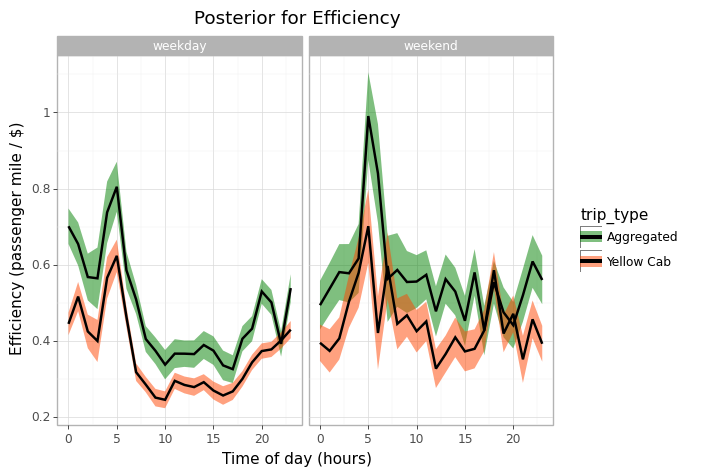

<ggplot: (8765608052933)>

In [33]:
# add time columns to trips
def add_time_cols(trips: pd.DataFrame):
    
    # add time of the day
    trips = trips.assign(hour=trips.pickup_datetime.dt.hour)
    
    # add weekday vs. weekend
    trips = trips.assign(weekday=['weekday'] * len(trips))
    trips.loc[trips.pickup_datetime.dt.weekday > 4, 'weekday'] = 'weekend'
    
    return trips

# format trips for plotting
n_samples = 5000
trips_plot = pd.concat([add_time_cols(trips.sample(n_samples, random_state=4)),
                        add_time_cols(agg_trips.sample(n_samples, random_state=4))])
trips_plot = trips_plot.assign(trip_type = ['Yellow Cab'] * n_samples + ['Aggregated'] * n_samples)

# define gaussian kernel for GPR
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 20)) * gp.kernels.RBF(10.0, (1e-3, 5))

# plot efficiency for NYC yellow cabs and aggregated rides across the day
eff_plot = (p9.ggplot(data=trips_plot, mapping=p9.aes(x='hour', y='efficiency', 
                                                     fill='trip_type')) +
           p9.theme_light() +
           p9.geom_smooth(alpha=0.5, method='gpr', method_args={'kernel': kernel,
                                                                'n_restarts_optimizer': 10,
                                                                'alpha': 0.25,
                                                                'normalize_y': True}) +
           p9.scale_fill_manual(values=["green", "#FF4500"]) +
           p9.facet_wrap('weekday') +
           p9.labels.labs(x='Time of day (hours)', y='Efficiency (passenger mile / $)') +
           p9.ggtitle('Posterior for Efficiency'))j hmbnn 
ggsave(filename='efficiency_plot.png', plot=eff_plot)
eff_plot


## Conclusions <a id=6></a>
---
* Doing geographical spatial analysis at this scale would be unfeasible without leveraging tree-based queries (speedups of > 1000x).
* Even without aggregating trips mid-route, aggregation results indicate that ride sharing could provide a more than 2-fold increase in efficiency when compared to Yellow Cabs (though it still does not beat bycicles in some routes!).
* From inspecting route maps, benefits from aggregation do not appear to be affected by location.
* Potentially due to my assumption that aggregation does not improve traffic, temporal patterns seem to affect aggregated rides and Yellow cabs similarly: noon is a low point for efficiency, due to high traffic and early in the morning and later in the evening are peaks for efficiency, due to a combination of low traffic and demand for cabs.


#### Things I would like to explore if I had more time / computing power:
1. Aggregate trips mid-route.
2. Account for driver idle time assuming work shift durations on the efficiency metric.
3. Account for lower traffic due to lower number of vehicles on the street when using aggressive aggregation.

In [49]:
share_map.save('share_map.html')